<a href="https://colab.research.google.com/github/davione112/HateSpeechDetection/blob/main/HSD_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install emot --upgrade
!pip install regex
!pip install pyvi

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from itertools import groupby
from sklearn.model_selection import train_test_split
import regex as re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from pyvi import ViTokenizer, ViPosTagger,ViUtils
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn import preprocessing
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%cd /content/drive/MyDrive/hate_speech_detection

/content/drive/MyDrive/hate_speech_detection


#Data Loader

In [ ]:
train = pd.read_csv("vihsd/vihsd/train.csv",index_col=False)
test = pd.read_csv("vihsd/vihsd/test.csv",index_col=False)
dev = pd.read_csv("vihsd/vihsd/dev.csv",index_col=False)

In [ ]:
data = pd.concat([train, dev, test], ignore_index=True)
data = data.drop_duplicates(keep='last').reset_index(drop=True)
data = data.dropna().reset_index(drop=True)

In [ ]:
train,test = train_test_split(data,test_size=0.3, random_state=0)
test,dev = train_test_split(test,test_size=1/3, random_state=0)

In [ ]:
# train, test, dev = np.split(data.sample(frac=1), [int(.7*len(data)), int(.9*len(data))])

In [ ]:
# dev = dev.drop_duplicates(keep='last').reset_index(drop=True)
# train = train.drop_duplicates(keep='last').reset_index(drop=True)

In [ ]:
print(train.shape, test.shape, dev.shape)
# (21592, 2) (6170, 2) (3085, 2)

(21592, 2) (6170, 2) (3085, 2)


In [ ]:
# train = train.dropna().reset_index(drop=True)
# dev = dev.dropna().reset_index(drop=True)

In [ ]:
# X_train = pd.concat([X_train, X_dev], ignore_index=True)

In [ ]:
# data = pd.concat([train, dev, test], ignore_index=True)

#Overview

## Remove duplicate

In [ ]:
# test = test.drop_duplicates(keep='last').reset_index(drop=True)
# dev = dev.drop_duplicates(keep='last').reset_index(drop=True)
# train = train.drop_duplicates(keep='last').reset_index(drop=True)
# print(train.shape,dev.shape,test.shape)

##Remove missing values

In [ ]:
# train = train.dropna().reset_index(drop=True)
# dev = dev.dropna().reset_index(drop=True)
# test = test.dropna().reset_index(drop=True)
# print(train.shape,dev.shape,test.shape)

##Count label

In [ ]:
def count_label(dataset):
  count = (train['label_id'].value_counts())
  sns.set()
  # labels = data.keys()
  count.plot(kind='pie', title='Number of label in training set', figsize=[8,8], startangle=90, shadow=True,
             colors=['#EAB315','#F1CB5F','#F7E4AF'],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*count.sum()))
  plt.show()

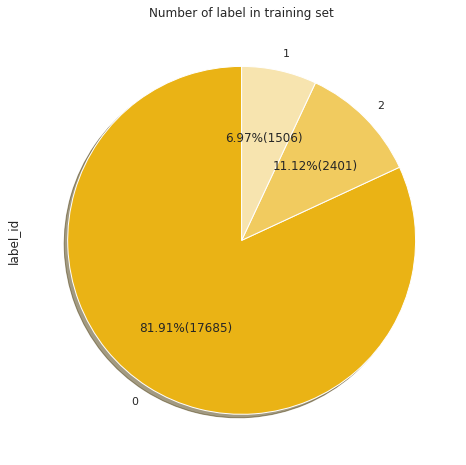

In [ ]:
count_label(train)

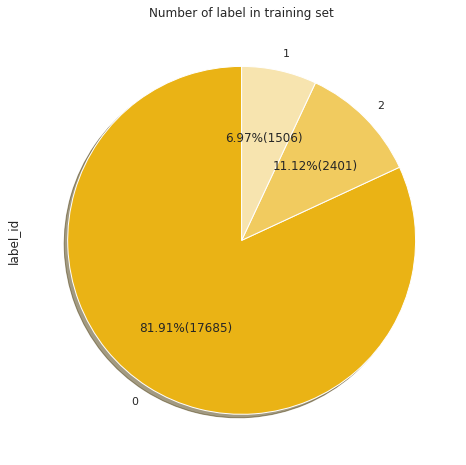

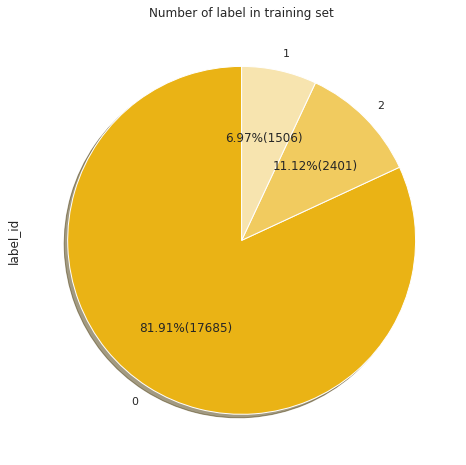

In [ ]:
count_label(dev)
count_label(test)

##Length of comment

In [ ]:
def length(dataset):
  l = []
  for i in train['free_text']:
    l.append(len(str(i).split()))
  l = pd.DataFrame(l, columns=['Length'])  
  l = (l.value_counts())
  sns.set()
  l.plot(kind='area', title='Length of comments in training set', figsize=[8,8], colormap='summer',
          )
  plt.show()

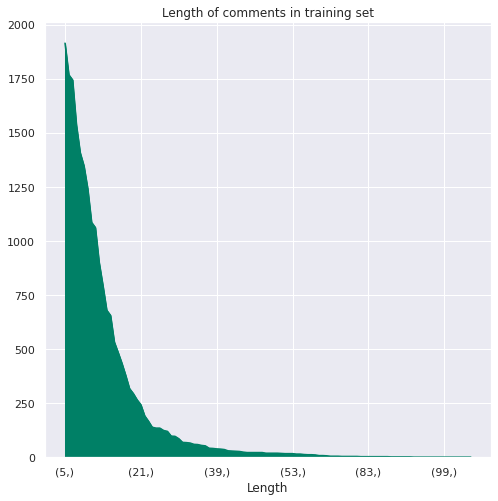

In [ ]:
length(train)

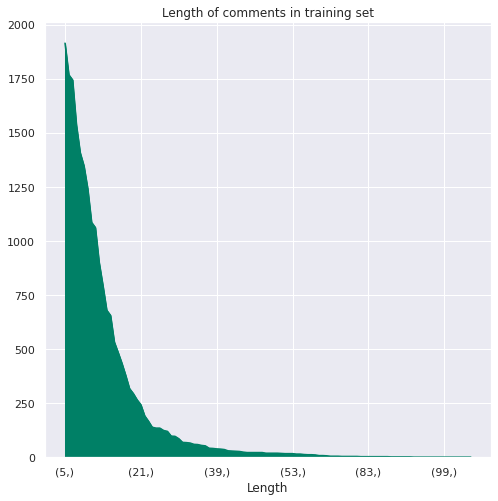

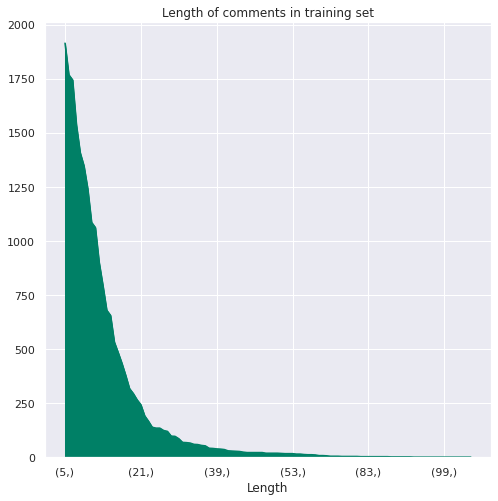

In [ ]:
length(dev)
length(test)

##Vocab

In [ ]:
def create_vocab(dataset):
  text = []
  for sentence in dataset['free_text']:
    text.extend(str(sentence).split())
  vocab = set(text)
  # print(groupby(text))
  #print(len(vocab),vocab)
  df = pd.DataFrame(list(vocab))
  return df

In [ ]:
text = []
for sentence in train['free_text']:
  text.extend(str(sentence).split())

In [ ]:
vocab = create_vocab(train)
vocab.to_csv('vocab.csv')

#Preprocessing

##Split dictionary to normal dict and special dict

In [ ]:
"""check repeated character in word"""
def check_repeated_character(text):
  text = re.sub('  +',' ',text).strip()
  count = {}
  for i in range(len(text)-1):
    if text[i] == text[i+1]:
      return True
  return False 
def check_space(text):#check space in string 
  for i in range(len(text)):
    if text[i]==' ':
      return True
  return False

def check_special_character_numberic(text):
  return any(not c.isalpha() for c in text)

abb_dict_normal=[]
abb_dict_special=[]
abb_dict = pd.read_excel('dictionary/abbreviation_dictionary_vn.xlsx', sheet_name='general')
for i in range(abb_dict.shape[0]):
  word = abb_dict['abbreviation'][i]
  meaning = abb_dict['meaning'][i]
  if  (check_repeated_character(word)) or (check_special_character_numberic(word)):# or (check_space(word)):#
    abb_dict_special.append([word, meaning])# including special character
  else:
    abb_dict_normal.append([word, meaning])# normal
abb_dict_normal = pd.DataFrame(abb_dict_normal, columns=['abbreviation','meaning'])
abb_dict_special = pd.DataFrame(abb_dict_special, columns=['abbreviation','meaning'])

abb_dict_normal.to_excel('dictionary/abb_dict_normal.xlsx',index=False)
abb_dict_special.to_excel('dictionary/abb_dict_special.xlsx',index=False)

##Function

In [ ]:
# Remove emoji and emoticons
def remove_emoji(text):
  for emot in UNICODE_EMOJI:
    text = str(text).replace(emot, ' ')
  text = re.sub('  +',' ',text).strip() 
  return text  
#Remove url
def url(text):
  text = re.sub(r'https?://\S+|www\.\S+', ' ',str(text))
  text = re.sub('  +',' ',text).strip()
  return text
#remove special character
def special_character(text):
  text = re.sub(r'\d+', lambda m: " ", text)
  # text = re.sub(r'\b(\w+)\s+\1\b',' ', text) #remove duplicate number word
  text = re.sub("[~!@#$%^&*()_+{}“”|:\"<>?`´\-=[\]\;\\\/.,]"," ",text)
  text = re.sub('  +',' ',text).strip()
  return text
#normalize repeated characters
def repeated_character(text):
  text = re.sub(r'(\w)\1+', r'\1', text) 
  text = re.sub('  +',' ',text).strip()
  return text
def mail(text):
  text = re.sub(r'[^@]+@[^@]+\.[^@]+',' ', text) 
  text = re.sub('  +',' ',text).strip()
  return text
#remove mention tag and hashtag
def tag(text):
  text = re.sub(r"(?:\@|\#|\://)\S+", " ", text) 
  text = re.sub('  +',' ',text).strip()
  return text
# """Remove all mixed words and numbers"""
def mixed_word_number(text):
  text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
  text = re.sub('  +',' ',text).strip()
  return text

#tokenize by lib Pyvi
def tokenize(text):
    text = str(text)
    text = ViTokenizer.tokenize(text)
    return text

# """Read file stop words """

# STOPWORDS = 'vietnamese-stopwords-dash.txt'
# with open(STOPWORDS, "r") as ins:
#     stopwords = []
#     for line in ins:
#         dd = line.strip('\n')
#         stopwords.append(dd)
#     stop_words = set(stopwords)

# """Filter stop words """

# def filter_stop_words(text):
#     new_sent = [word for word in text.split() if word not in stop_words]
#     sentence = ' '.join(new_sent)        
#     return sentence

""" emoji """

character2emoji = pd.read_excel('dictionary/character2emoji.xlsx')#character to emoji
def convert_character2emoji(text):
  text=str(text)
  for i in range(character2emoji.shape[0]):
    text = text.replace(character2emoji.at[i,'character'], " "+character2emoji.at[i,'emoji']+" ")
  text = re.sub('  +',' ',text).strip()
  return text

emoji2word = pd.read_excel('dictionary/emoji2word.xlsx')#emoji to word
def convert_emoji2word(text):
  for i in range(emoji2word.shape[0]):
    text = text.replace(emoji2word.at[i,'emoji'], " "+emoji2word.at[i,'word_vn']+" ")
  text = re.sub('  +',' ',text).strip()
  return text

""" abbreviation """

abb_dict_normal = pd.read_excel("dictionary/abb_dict_normal.xlsx")
def abbreviation_normal(text):#len word equal 1
  text = str(text)
  temp=''
  for word in text.split():
    for i in range(abb_dict_normal.shape[0]):
      if str(abb_dict_normal.at[i,'abbreviation']) == str(word):
        word = str(abb_dict_normal.at[i,'meaning']) 
    temp = temp + ' '+ word
  text = temp
  text = re.sub('  +',' ',text).strip()
  return text  

abb_dict_special = pd.read_excel("dictionary/abb_dict_special.xlsx")
def abbreviation_special(text):#including special character and number
  text = ' '+str(text)+' '
  for i in range(abb_dict_special.shape[0]):
    text = text.replace(' '+abb_dict_special.at[i,'abbreviation']+' ' , ' '+abb_dict_special.at[i,'meaning']+' ')
  text = re.sub('  +',' ',text).strip()
  return text  

def special_character_1(text):#remove dot and comma
  text = re.sub("[.,?!]"," ",text)
  text = re.sub('  +',' ',text).strip()
  return text

def abbreviation_kk(text):
  text = str(text)
  for t in text.split():
    if 'kk' in t:
      text = text.replace(t,' ha ha ')
    else :
      if 'kaka' in t:
        text = text.replace(t,' ha ha ')
      else:
         if 'kiki' in t:
            text = text.replace(t,' ha ha ')
         else:
          if 'haha' in t:
            text = text.replace(t,' ha ha ')
          else:
            if 'hihi' in t:
              text = text.replace(t,' ha ha ')
  text = re.sub('  +',' ',text).strip()
  return text  

##duplicate abb

### create dataset of duplicate abb

In [ ]:
duplicate_abb = pd.read_excel('dictionary/abbreviation_dictionary_vn.xlsx', sheet_name='duplicate',header=None)
duplicate_abb = list(duplicate_abb[0])

In [ ]:
# def create_duplicate_abb_data(dataset,name):
#   temp_list = []
#   for i in range(dataset.shape[0]):
#     comment = str(dataset.at[i,'free_text'])
#     cmt = ' ' + comment + ' '
#     for abb in duplicate_abb:   
#       start_index = 0
#       while start_index >-1: #start_index = -1 -> abb is not in cmt
#         start_index = cmt.find(' '+abb+' ')    #find will return FIRST index abb in cmt  
#         if start_index > -1:      
#           end_index = start_index + len(abb)
#           temp_list.append([abb,start_index,end_index,comment])
#           for i in range(start_index+1,end_index+1):#replace abb to space ' '
#             cmt = cmt[:i] + ' '+ cmt[i+1:]
#   temp_df = pd.DataFrame(temp_list,columns=['abb','start_index','end_index','cmt'])
#   temp_df.to_excel('dictionary/'+name+'_duplicate_abb_data'+'.xlsx',index=False) 

In [ ]:
# create_duplicate_abb_data(dev,'dev')
# create_duplicate_abb_data(train,'train')
# create_duplicate_abb_data(test,'test')

###predict duplicate abb

In [ ]:

def annotations(dataset):
  pos = []
  max_len = 8000
  for i in range(dataset.shape[0]):
    n = len(dataset.at[i,'cmt'])
    l = [0] * max_len
    for j in range(dataset.at[i,'start_index'], dataset.at[i,'end_index']):
      l[j] = 1
    pos.append(l)
  return pos
train_duplicate_abb_data = pd.read_excel('dictionary/train_duplicate_abb_data.xlsx')
dev_duplicate_abb_data = pd.read_excel('dictionary/dev_duplicate_abb_data.xlsx')
test_duplicate_abb_data = pd.read_excel('dictionary/test_duplicate_abb_data.xlsx')
duplicate_abb_data = pd.concat([train_duplicate_abb_data, dev_duplicate_abb_data, test_duplicate_abb_data], ignore_index=True)
duplicate_abb_data = duplicate_abb_data.drop_duplicates(keep='last').reset_index(drop=True)
max_len=0

X = duplicate_abb_data[['abb','start_index','end_index','cmt']]
y = duplicate_abb_data['origin']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
enc = DictVectorizer()
Tfidf_vect = TfidfVectorizer(max_features=1200)

temp = annotations(X)
X_pos = sparse.csr_matrix(np.asarray(temp))
X_abb = enc.fit_transform(X[['abb']].to_dict('records'))
X_text= Tfidf_vect.fit_transform(X['cmt'])
X = hstack((X_abb,X_pos,X_text))

# X_train_abb,  X_test_abb, y_train_abb,y_test_abb = train_test_split(X, y, test_size=0.2, random_state=0)
y = to_categorical(y)
# y_test_abb = to_categorical(y_test_abb)
abb_model = Ridge(alpha=1.0).fit(X, y)
joblib.dump(abb_model, 'save_model/abb_model.sav')
y_pred_abb = abb_model.predict(X)
print(classification_report(y_pred_abb.argmax(axis=1), y.argmax(axis=1), digits = 4))

              precision    recall  f1-score   support

           0     0.9130    0.9545    0.9333        22
           1     1.0000    1.0000    1.0000         1
           2     0.9545    1.0000    0.9767        21
           3     1.0000    0.9219    0.9593        64
           4     0.7778    1.0000    0.8750        14
           5     1.0000    0.9400    0.9691        50
           6     0.7500    1.0000    0.8571         3
           7     1.0000    1.0000    1.0000         1
           8     1.0000    1.0000    1.0000         1
           9     1.0000    1.0000    1.0000         8
          10     1.0000    1.0000    1.0000         1
          11     0.0000    0.0000    0.0000         0
          12     0.6000    1.0000    0.7500         3
          13     1.0000    0.9474    0.9730       190
          14     0.0000    0.0000    0.0000         0
          15     1.0000    1.0000    1.0000        21
          16     1.0000    1.0000    1.0000         2
          17     1.0000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 
def abbreviation_predict(t):
  loaded_model = joblib.load('save_model/abb_model.sav')
  text = str(t)
  max_len = 8000
  if len(t)>max_len:
    text =t[:max_len]
    
  cmt = ' ' + text + ' '
  for abb in duplicate_abb:   
    start_index = 0
    count = 0
    while start_index >-1: #start_index = -1 -> abb is not in cmt
      start_index = cmt.find(' '+abb+' ')    #find will return FIRST index abb in cmt  
      if start_index > -1:      
        end_index = start_index + len(abb)
        t = pd.DataFrame([[abb, start_index, end_index, text]], columns=['abb', 'start_index', 'end_index','cmt'],index=None)
        temp = annotations(t)
        X_pos = sparse.csr_matrix(np.asarray(temp))
        X_abb = enc.transform(t[['abb']].to_dict('records'))
        # print(t['cmt'])
        X_text= Tfidf_vect.transform([text])
        
        X = hstack((X_abb,X_pos,X_text))
        predict = loaded_model.predict(X)        
        origin = le.inverse_transform(predict.argmax(axis=1))
        origin = ''.join(origin)
        text = text[:start_index+count*(len(origin)-len(abb))]+origin+text[end_index+count*(len(origin)-len(abb)):]
        text = ''.join(text)
        count = count + 1
        for i in range(start_index+1,end_index+1):#replace abb to space ' '
          cmt = cmt[:i] + ' '+ cmt[i+1:]        
  return text      


## preprocessing

In [ ]:
def preprocessing(dataset):
  dataset['free_text'] = dataset['free_text'].str.lower() 
  dataset['free_text'] = dataset['free_text'].apply(convert_character2emoji)
  dataset['free_text'] = dataset['free_text'].apply(url)
  dataset['free_text'] = dataset['free_text'].apply(mail)
  dataset['free_text'] = dataset['free_text'].apply(tag)
  dataset['free_text'] = dataset['free_text'].apply(mixed_word_number)
  dataset['free_text'] = dataset['free_text'].apply(special_character_1)  # ##remove , . ? !
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_kk)  
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_special)
  dataset['free_text'] = dataset['free_text'].apply(convert_character2emoji) 
  dataset['free_text'] = dataset['free_text'].apply(remove_emoji)
  dataset['free_text'] = dataset['free_text'].apply(repeated_character) 
  dataset['free_text'] = dataset['free_text'].apply(special_character)  
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_normal)  
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_predict)  
  dataset['free_text'] = dataset['free_text'].apply(tokenize)
  return dataset

In [ ]:
train = preprocessing(train)
dev = preprocessing(dev)
test = preprocessing(test)

In [ ]:
# print(train.shape,dev.shape,test.shape)
# dev = dev.drop_duplicates(keep='last').dropna().reset_index(drop=True)
# train = train.drop_duplicates(keep='last').dropna().reset_index(drop=True)
# print(train.shape,dev.shape,test.shape)

In [ ]:
vocab = create_vocab(train)
print(len(vocab))
#16265
#16597
#14580 ko xoa url, mail, tag

13309


##Save dataset

In [ ]:
vocab.to_excel('preprocessed_data/vocab.xlsx',index=None)
train.to_excel("preprocessed_data/train.xlsx",index=None)
dev.to_excel("preprocessed_data/dev.xlsx",index=None)
test.to_excel("preprocessed_data/test.xlsx",index=None)

#Training

##Load dataset

In [ ]:
preprocessed_train = pd.read_excel("preprocessed_data/train.xlsx")
preprocessed_dev = pd.read_excel("preprocessed_data/dev.xlsx")
preprocessed_test = pd.read_excel("preprocessed_data/test.xlsx")
vocab = pd.read_excel('preprocessed_data/vocab.xlsx')

In [ ]:
max = 0
for i in range(preprocessed_train.shape[0]):
  t = str(preprocessed_train.at[i,'free_text']).replace('_',' ')
  if max<len(t):
    max = len(t)
max

7554

In [ ]:
max

7554

In [ ]:
max = 0
for i in range(preprocessed_dev.shape[0]):
  t = str(preprocessed_dev.at[i,'free_text']).replace('_',' ')
  if max<len(t):
    max = len(t)
max

732

In [ ]:
max = 0
for i in range(preprocessed_test.shape[0]):
  t = str(preprocessed_test.at[i,'free_text']).replace('_',' ')
  if max<len(t):
    max = len(t)
max

4609

In [ ]:
preprocessed_test.shape

(6170, 2)

In [ ]:
# preprocessed_test = preprocessed_test.dropna().reset_index(drop=True)

In [ ]:
preprocessed_test.shape

(6170, 2)

In [ ]:
X_train = preprocessed_train['free_text']
y_train = preprocessed_train['label_id'].values
X_dev = preprocessed_dev['free_text']
y_dev = preprocessed_dev['label_id'].values
X_test = preprocessed_test['free_text']
y_test = preprocessed_test['label_id'].values

In [ ]:
X_train = pd.concat([X_train, X_dev], ignore_index=True)
y_train = np.concatenate((y_train,y_dev),axis = 0)

##Word cloud

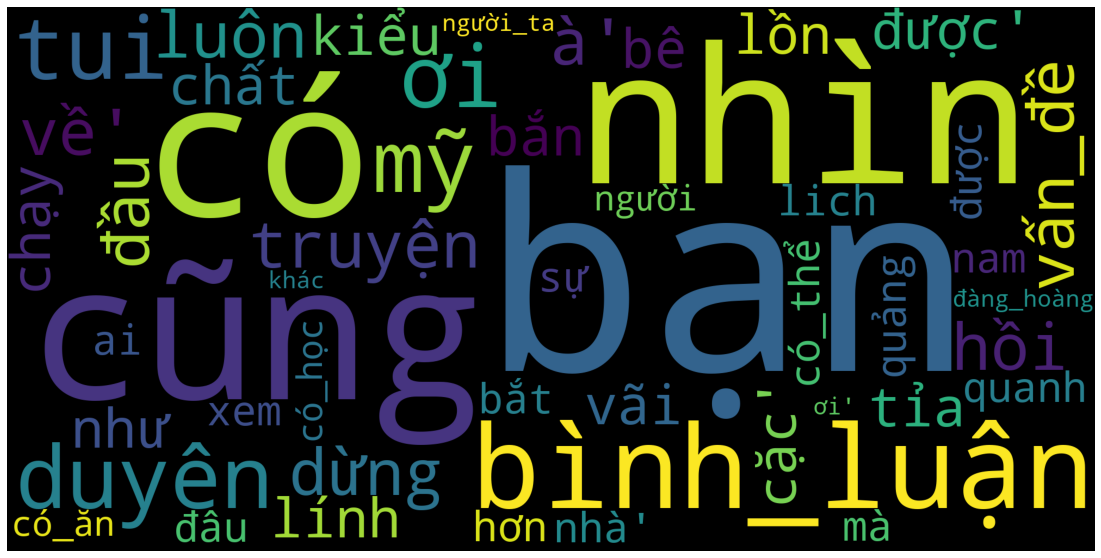

In [ ]:
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
cloud = np.array(X_train).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

##ML

## TF-IDF

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=len(vocab))
X_train = Tfidf_vect.fit_transform(X_train.values.astype('U'))
X_test = Tfidf_vect.transform(X_test.values.astype('U'))
clf = LogisticRegression(C=10, penalty= 'l2').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9657    0.9035    0.9335      5387
           1     0.3126    0.5094    0.3875       267
           2     0.4921    0.6628    0.5648       516

    accuracy                         0.8663      6170
   macro avg     0.5901    0.6919    0.6286      6170
weighted avg     0.8978    0.8663    0.8791      6170



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Find best hyperparameter

###LR

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import fbeta_score, make_scorer
# param_grid = {  'C': [ 0.1, 1, 10, 100,1000],
#               }
# clf = LogisticRegression()#class_weight = 'balanced')

# scoring =make_scorer(f1_score, average='macro')
# g_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                         cv = 5, 
#                         return_train_score=True,
#                         scoring = scoring
#                         )
# g_search.fit(X_train, y_train)

# print(g_search.best_params_)

###SVM